In [6]:
# Exam Analytics Mini Project  
### Difficulty Estimation + Cheating Risk Detection  
### Inspired by SAFE (Smart, Authenticated, Fast Exams & Grading)

## ---

## 1. Import Libraries

## 2. Load Data

## 3. Question Difficulty Estimation

## 4. Cheating Risk Scoring

## 5. Visualizations (Difficulty & Cheating Patterns)

## 6. Generate HTML Report

In [31]:
!pip install numpy pandas matplotlib seaborn pathlib

In [8]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv(r"C:\Users\Sachin\Downloads\project.csv") #Load data

# Group by question to calculate metrics
difficulty_scores = (
    df.groupby('question_id')
    .agg(
        correct_rate = ('is_correct', 'mean'),
        avg_time = ('time_taken', 'mean'),
        attempts = ('is_correct', 'count')
    )
    .reset_index()
)

# Compute basic difficulty (lower correct rate = more difficult)
difficulty_scores['difficulty'] = 1 - difficulty_scores['correct_rate']

# Adjust difficulty using average time (longer avg_time → harder)
difficulty_scores['adjusted_difficulty'] = (
    difficulty_scores['difficulty'] + 
    (difficulty_scores['avg_time'] / difficulty_scores['avg_time'].max())
)

difficulty_scores

,question_id,correct_rate,avg_time,attempts,difficulty,adjusted_difficulty
0,1,0.8,20.4,5,0.2,0.612955
1,2,0.6,49.4,5,0.4,1.400000
2,3,0.8,13.6,5,0.2,0.475304


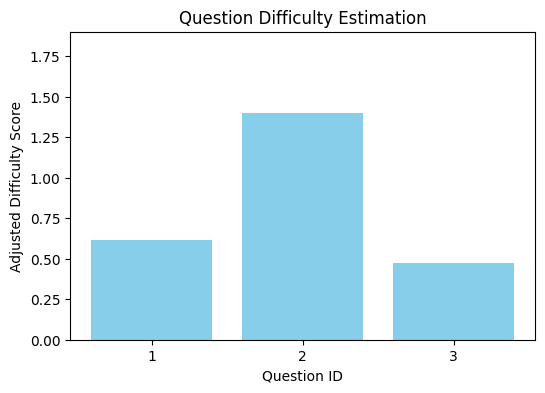

In [19]:
import matplotlib.pyplot as plt

# Bar chart for adjusted difficulty
plt.figure(figsize=(6,4))
plt.bar(difficulty_scores['question_id'], difficulty_scores['adjusted_difficulty'], color='skyblue')
plt.xlabel('Question ID')
plt.ylabel('Adjusted Difficulty Score')
plt.title('Question Difficulty Estimation')
plt.xticks(difficulty_scores['question_id'])
plt.ylim(0, max(difficulty_scores['adjusted_difficulty']) + 0.5)  # optional padding
plt.savefig("difficulty_plot.png", dpi=300)
plt.show()

In [20]:
# Copy dataframe to work with
df_cheat = df.copy()

# Define thresholds
time_threshold = df_cheat['time_taken'].quantile(0.10)  # very fast answers
switch_threshold = df_cheat['switches'].median()        # high switch count

# Initialize cheat risk score
df_cheat['cheat_risk'] = 0

# Rule 1: very fast correct answers
df_cheat.loc[(df_cheat['time_taken'] < time_threshold) & (df_cheat['is_correct'] == 1), 'cheat_risk'] += 1

# Rule 2: high number of switches
df_cheat.loc[df_cheat['switches'] > switch_threshold, 'cheat_risk'] += 1

# Convert numeric score to label
df_cheat['risk_label'] = df_cheat['cheat_risk'].apply(
    lambda x: 'High' if x > 1 else ('Medium' if x == 1 else 'Low')
)

# Show results
df_cheat[['student_id','question_id','is_correct','time_taken','switches','cheat_risk','risk_label']]

,student_id,question_id,is_correct,time_taken,switches,cheat_risk,risk_label
0,101,1,1,32,1,0,Low
1,101,2,0,110,4,1,Medium
2,101,3,1,25,0,0,Low
3,102,1,1,15,0,0,Low
4,102,2,1,20,1,0,Low
5,102,3,0,5,0,0,Low
6,103,1,0,5,0,0,Low
7,103,2,1,14,2,1,Medium
8,103,3,1,18,1,0,Low
9,104,1,1,40,3,1,Medium


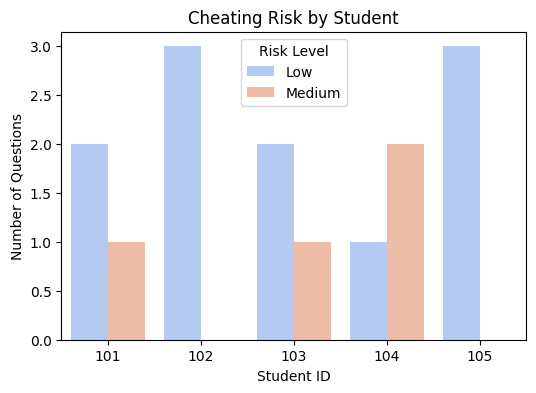

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of risk labels per student
plt.figure(figsize=(6,4))
sns.countplot(x='student_id', hue='risk_label', data=df_cheat, palette='coolwarm')
plt.title('Cheating Risk by Student')
plt.xlabel('Student ID')
plt.ylabel('Number of Questions')
plt.legend(title='Risk Level')
plt.show()

In [24]:
import os

# Create folder if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

# Now save the file
df_cheat.to_csv("data/cheating_risk.csv", index=False)
print("Cheating risk results saved to cheating_risk.csv")

Cheating risk results saved to cheating_risk.csv


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import base64

def fig_to_base64(fig):
    """Convert matplotlib figure to base64 string for embedding in HTML."""
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close(fig)
    return img_base64

def generate_report(csv_path, output_html="dataset_report.html"):
    df = pd.read_csv(csv_path)
    
    html = f"""
    <html>
    <head>
        <title>Dataset Report</title>
        <style>
            body {{ font-family: Arial; margin: 20px; }}
            h2 {{ color: #2F4F4F; }}
            table {{ border-collapse: collapse; margin-bottom: 20px; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; }}
            th {{ background-color: #f2f2f2; }}
            img {{ max-width: 600px; margin-bottom: 20px; }}
            .insight {{ background-color: #f9f9f9; padding: 10px; border-left: 4px solid #2F4F4F; margin-bottom: 20px; }}
        </style>
    </head>
    <body>
        <h1>Dataset Report</h1>
    """

    # --- Dataset Overview ---
    html += f"<h2>Dataset Overview</h2>"
    html += f"<p>Rows: {df.shape[0]}, Columns: {df.shape[1]}</p>"
    
    # --- Missing Values ---
    missing = df.isnull().sum()
    html += "<h3>Missing Values</h3>"
    html += missing.to_frame("Missing Values").to_html()
    
    # --- Column Types ---
    html += "<h3>Column Types</h3>"
    html += df.dtypes.to_frame("Type").to_html()
    
    # --- Basic Statistics ---
    html += "<h3>Basic Statistics</h3>"
    html += df.describe(include="all").to_html()
    
    # --- Insights ---
    html += "<h2>Automated Insights</h2>"
    
    # Most missing values
    if missing.max() > 0:
        col_missing = missing.idxmax()
        html += f'<div class="insight">Column with most missing values: <b>{col_missing}</b> ({missing.max()} missing)</div>'
    
    # High correlation
    numeric_cols = df.select_dtypes(include='number').columns
    if len(numeric_cols) > 1:
        corr = df[numeric_cols].corr().abs()
        corr_unstack = corr.where(~np.eye(corr.shape[0],dtype=bool)).stack()
        if not corr_unstack.empty:
            high_corr = corr_unstack.idxmax()
            html += f'<div class="insight">Highest correlation: <b>{high_corr[0]}</b> and <b>{high_corr[1]}</b> ({corr_unstack.max():.2f})</div>'
    
    # --- Visualizations ---
    html += "<h2>Visualizations</h2>"
    
    # Numeric columns
    for col in numeric_cols:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        sns.histplot(df[col].dropna(), kde=True, bins=20, ax=ax[0])
        ax[0].set_title(f'Histogram of {col}')
        sns.boxplot(x=df[col], ax=ax[1])
        ax[1].set_title(f'Boxplot of {col}')
        img_base64 = fig_to_base64(fig)
        html += f'<img src="data:image/png;base64,{img_base64}" alt="{col}">'
    
    # Categorical columns
    categorical_cols = df.select_dtypes(include='object').columns
    for col in categorical_cols:
        fig, ax = plt.subplots(figsize=(6,4))
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'Value Counts of {col}')
        img_base64 = fig_to_base64(fig)
        html += f'<img src="data:image/png;base64,{img_base64}" alt="{col}">'
    
    # Correlation Heatmap
    if len(numeric_cols) > 1:
        fig, ax = plt.subplots(figsize=(8,6))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', ax=ax)
        ax.set_title('Correlation Heatmap')
        img_base64 = fig_to_base64(fig)
        html += f'<img src="data:image/png;base64,{img_base64}" alt="Correlation Heatmap">'
    
    html += "</body></html>"
    
    with open(output_html, "w", encoding="utf-8") as f:
        f.write(html)
    
    print(f"Report generated: {output_html}")

# --- Usage ---
generate_report(r"C:\Users\Sachin\Downloads\project.csv")

Report generated: dataset_report.html
